CS4287 Nueral Networks - Assignment 2 - CNN - 17206413

Before starting, please ensure that both of the zip files is contained within the same folder as this .ipynb file

In [1]:
#imports for the Data Read
import os
import pandas as pd
from numpy import expand_dims
import numpy as np
import zipfile

In [2]:
#Find cureent directory and open DATA_08_11.zip file
curDir = os.getcwd()
zf = zipfile.ZipFile(curDir + '/DATA_08_11.zip')
text_files = zf.infolist()

In [3]:
#Find cureent directory and open CVS.zip file
zf1 = zipfile.ZipFile(curDir + '/CSV.zip')
text_files1 = zf1.infolist()

In [4]:
#Read results info
resultsList = []

print ("Uncompressing and reading results data... ")

for text_file in text_files:
    if text_file.filename.startswith("DATA_08_11/players"):
        s = pd.read_csv(zf.open(text_file.filename))
        resultsList.append(s)

for text_file in text_files1:
    if text_file.filename.startswith("CSV/players"):
        s = pd.read_csv(zf1.open(text_file.filename))
        resultsList.append(s)

resultsData = pd.concat(resultsList).drop(columns=['Unnamed: 0'])

print ("Results data ready")
resultsData.head()

Uncompressing and reading results data... 
Results data ready


,MapId,Win Rate,Loss Rate,Draw Rate
0,1.031550e+09,483.0,485.0,32.0
1,4.669434e+08,361.0,506.0,133.0
2,1.240357e+09,756.0,214.0,30.0
3,1.930428e+09,444.0,362.0,194.0
4,6.103805e+08,617.0,367.0,16.0


In [5]:
# Read map info and attach correct results
imagesList = []
labelsList = []
currentMap = []

print ("Uncompressing and reading map data... ")

for text_file in text_files:
    if text_file.filename.startswith("DATA_08_11/map"):
        splited = text_file.filename.split("map_", 1)
        filename = splited[1].split(".",1)
        id = int(filename[0])
        #find the results for that particualr map
        result = resultsData.loc[resultsData['MapId'] == id].values.astype(int)
        #only using maps that have results info
        if result.size != 0:
            currentMap = pd.read_csv(zf.open(text_file.filename),header=0).to_numpy().reshape(49, 49)
            imagesList.append([currentMap])
            #set results to either 0 or 1 for logistic regression. would have used linear regression for determining % chance of win.
            if (result[0][1]/(result[0][1]+result[0][2]+result[0][3]))>0.5:
              labelsList.append(1)
            else :
              labelsList.append(0)

for text_file in text_files1:
    if text_file.filename.startswith("CSV/map"):
        splited = text_file.filename.split("map_", 1)
        filename = splited[1].split(".",1)
        id = int(filename[0])
        #find the results for that particualr map
        result = resultsData.loc[resultsData['MapId'] == id].values.astype(int)
        #only using maps that have results info
        if result.size != 0:
            currentMap = pd.read_csv(zf1.open(text_file.filename),header=0).to_numpy().reshape(49, 49)
            imagesList.append([currentMap])
            #set results to either 0 or 1 for logistic regression. tried multinominal logistic regression but eh loss and accuracy were both terrible. Linear regression would have worked better for determining % chance of win.
            if (result[0][1]/(result[0][1]+result[0][2]+result[0][3]))>0.5:
              labelsList.append(1)
            else :
              labelsList.append(0)

print ("Map data ready")

Uncompressing and reading map data... 
Map data ready


In [6]:
#convert all values to numpy
images = np.array(imagesList)
labels = np.array(labelsList)
print("labels: ",len(labels),"images: ", images.shape)

labels:  20454 images:  (20454, 1, 49, 49)


In [7]:
#close the zip readers
zf.close()
zf1.close()

In [8]:
#imports for the model definitions/ preprocessing and graphing
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
import matplotlib.pyplot as plt
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [9]:
#Split Data into Train 60%, val 20%, test 20%
images_train, images_val_and_test, labels_train, labels_val_and_test = train_test_split(images, labels, test_size=0.4, random_state=5)
images_val, images_test, labels_val, labels_test = train_test_split(images_val_and_test, labels_val_and_test, test_size=0.5, random_state=7)
print(len(images_train), len(images_val), len(images_test), len(labels_train), len(labels_val), len(labels_test))

12272 4091 4091 12272 4091 4091


In [10]:
#check image array shape
images_train.shape[1:]

(1, 49, 49)

In [11]:
#reshape data form channel first to channel last
nDims, nRows,nCols= images_train.shape[1:]
train_data = images_train.reshape(images_train.shape[0],nRows, nCols, nDims)
test_data = images_test.reshape(images_test.shape[0], nRows, nCols, nDims)
val_data = images_val.reshape(images_val.shape[0],nRows, nCols, nDims)
input_shape = ( nRows, nCols, nDims)

train_data = train_data.astype(int)
test_data = test_data.astype(int)
val_data = val_data.astype(int)

train_data.shape
#data is now reshaped correctly (only using one channel as dataimagegenerator does not work on 5 channel, Also as the data in each cell is not overlapping (unlike RGB images), i do not see the need for multiple channels)

(12272, 49, 49, 1)

In [12]:
#create datagens for train, val and test to use real time Data Augmentaion in model.fit()
train_datagen = ImageDataGenerator(
	featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=0, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=True,
    vertical_flip=True, rescale=None, preprocessing_function=None,
    data_format=None, validation_split=0.0, dtype=None)

train_datagen.fit(train_data)

val_datagen = ImageDataGenerator(
	featurewise_center=False, samplewise_center=False,
	featurewise_std_normalization=False, samplewise_std_normalization=False,
	zca_whitening=False, zca_epsilon=0, rotation_range=0, width_shift_range=0.0,
	height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
	channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=True,
	vertical_flip=True, rescale=None, preprocessing_function=None,
	data_format=None, validation_split=0.0, dtype=None)

val_datagen.fit(val_data)

test_datagen = ImageDataGenerator(
	featurewise_center=False, samplewise_center=False,
	featurewise_std_normalization=False, samplewise_std_normalization=False,
	zca_whitening=False, zca_epsilon=0, rotation_range=0, width_shift_range=0.0,
	height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
	channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=True,
	vertical_flip=True, rescale=None, preprocessing_function=None,
	data_format=None, validation_split=0.0, dtype=None)
	

test_datagen.fit(test_data)

In [13]:
#model definition with regularization using dropout, kernal regularizer and batch normalisation
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu',input_shape=input_shape, kernel_regularizer='l2'))
BatchNormalization(),
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.6))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128 ,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 47, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 33856)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4333696   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [14]:
#Early stopper
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

#Training
history = model.fit(train_datagen.flow(train_data, labels_train, batch_size=32),
          callbacks=[es],
          steps_per_epoch=len(train_data)/32, 
          epochs=30,
          verbose=1,
          validation_data=val_datagen.flow(val_data, labels_val, batch_size=32))

Epoch 1/30
384/383 [==============================] - 64s 167ms/step - loss: 0.6704 - accuracy: 0.6333 - val_loss: 0.6768 - val_accuracy: 0.6277
Epoch 2/30
384/383 [==============================] - 91s 236ms/step - loss: 0.6557 - accuracy: 0.6350 - val_loss: 0.6595 - val_accuracy: 0.6282
Epoch 3/30
384/383 [==============================] - 88s 229ms/step - loss: 0.6484 - accuracy: 0.6415 - val_loss: 0.6615 - val_accuracy: 0.6282
Epoch 4/30
384/383 [==============================] - 98s 256ms/step - loss: 0.6484 - accuracy: 0.6380 - val_loss: 0.6525 - val_accuracy: 0.6289
Epoch 5/30
384/383 [==============================] - 61s 160ms/step - loss: 0.6479 - accuracy: 0.6383 - val_loss: 0.6511 - val_accuracy: 0.6309
Epoch 6/30
384/383 [==============================] - 68s 176ms/step - loss: 0.6456 - accuracy: 0.6383 - val_loss: 0.6519 - val_accuracy: 0.6282
Epoch 7/30
384/383 [==============================] - 84s 220ms/step - loss: 0.6439 - accuracy: 0.6383 - val_loss: 0.6488 - val_ac

In [15]:
# I couldn't for the life of me, fix the overfitting

In [20]:
#Final Evaluation
test_results = np.around(model.evaluate(test_datagen.flow(test_data, labels_test)),2)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

128/128 [==============================] - 4s 27ms/step - loss: 0.6412 - accuracy: 0.6409
Test results - Loss: 0.64 - Accuracy: 64.0%


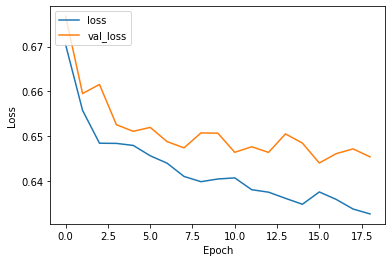

In [21]:
#Loss Graph
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

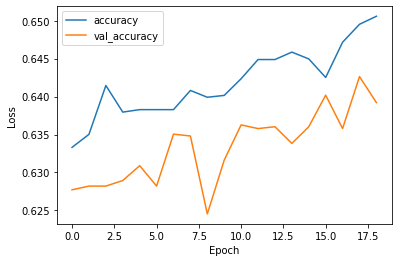

In [22]:
#Accuracy Graph 
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

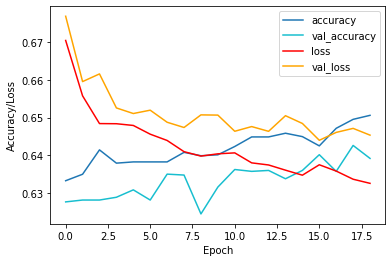

In [23]:
#Combined Results
plt.plot(history.history['accuracy'], label='accuracy', color='tab:blue')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy', color='tab:cyan')
plt.plot(history.history['loss'], label='loss', color='red')
plt.plot(history.history['val_loss'], label = 'val_loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend(loc='best')